In [1]:
import pandas as pd

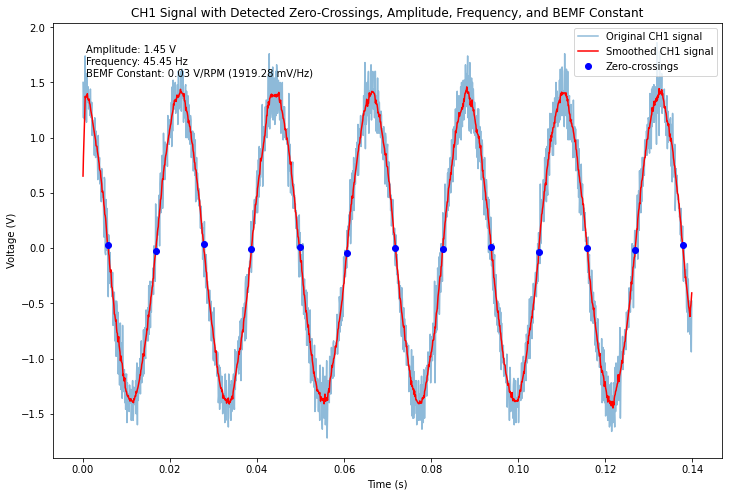

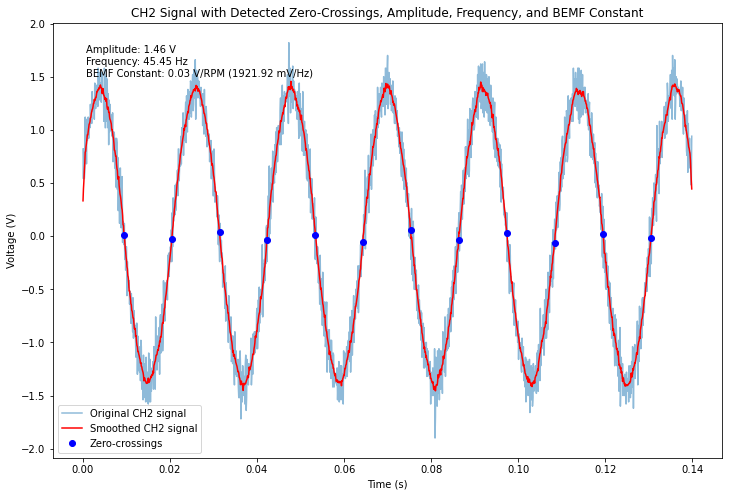

In [27]:
import pandas as pd
import numpy as np
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
from reportlab.pdfgen import canvas
from reportlab.lib.pagesizes import letter, landscape
from reportlab.platypus import SimpleDocTemplate, Table, TableStyle
from reportlab.lib import colors

# Function to calculate circular mean with symmetric window
def circular_mean(data, window_size):
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(data, window, 'same')

# Function to find zero crossings
def find_zero_crossings(data):
    zero_crossings = np.where(np.diff(np.sign(data)))[0]
    return zero_crossings

# Load the data
data = pd.read_csv('measurements/df45l024053-a2_slow.csv')


# Get the time increment from the original data
time_increment = float(data['Increment'].iloc[0])

# Remove the first row (unit labels)
data = data.iloc[1:]

# Convert the data to the correct types
data['X'] = pd.to_numeric(data['X'])
data['CH1'] = pd.to_numeric(data['CH1'])
data['CH2'] = pd.to_numeric(data['CH2'])

# Set the window size for circular mean
window_size = 10

# Calculate the circular mean of the signals
CH1_smooth = circular_mean(data['CH1'], window_size)
CH2_smooth = circular_mean(data['CH2'], window_size)

# Create a time array based on the number of samples and the time increment
time_array = np.arange(0, len(data['X']) * time_increment, time_increment)

# Find the zero-crossings
zero_crossings_CH1 = np.ravel(find_zero_crossings(CH1_smooth))
zero_crossings_CH2 = np.ravel(find_zero_crossings(CH2_smooth))

# Use these zero-crossings to calculate the period and frequency
period_CH1 = np.mean(np.diff(time_array[zero_crossings_CH1]))
period_CH2 = np.mean(np.diff(time_array[zero_crossings_CH2]))

# Correct the frequency calculation by dividing the frequency by 2
frequency_CH1 = 1 / period_CH1 / 2
frequency_CH2 = 1 / period_CH2 / 2

# Calculate amplitude in the smoothed signal using maxima and minima
amplitude_CH1 = (np.max(CH1_smooth) - np.min(CH1_smooth)) / 2
amplitude_CH2 = (np.max(CH2_smooth) - np.min(CH2_smooth)) / 2

# Calculate the BEMF constant
kt_CH1 = amplitude_CH1 / (frequency_CH1)  # Convert frequency from Hz to RPM
kt_CH2 = amplitude_CH2 / (frequency_CH2)

# Convert the BEMF constant to mV/Hz
kt_mV_Hz_CH1 = kt_CH1 * 1000  # Convert V/Hz to mV/Hz
kt_mV_Hz_CH2 = kt_CH2 * 1000  # Convert V/Hz to mV/Hz


# Plot the original and smoothed signals for CH1
plt.figure(figsize=(12, 8))
plt.plot(time_array, data['CH1'].values, label='Original CH1 signal', alpha=0.5)
plt.plot(time_array, CH1_smooth, 'r', label='Smoothed CH1 signal')

# Plot the zero-crossings
plt.plot(time_array[zero_crossings_CH1], CH1_smooth[zero_crossings_CH1], 'bo', label='Zero-crossings')

# Add the amplitude, frequency, and BEMF constant to the plot
plt.text(0.05, 0.95, f'Amplitude: {amplitude_CH1:.2f} V\nFrequency: {frequency_CH1:.2f} Hz\nBEMF Constant: {kt_CH1:.2f} V/RPM ({kt_mV_Hz_CH1:.2f} mV/Hz)',
         transform=plt.gca().transAxes, va='top')

plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.title('CH1 Signal with Detected Zero-Crossings, Amplitude, Frequency, and BEMF Constant')
plt.legend()

# Repeat the process for CH2
plt.figure(figsize=(12, 8))
plt.plot(time_array, data['CH2'].values, label='Original CH2 signal', alpha=0.5)
plt.plot(time_array, CH2_smooth, 'r', label='Smoothed CH2 signal')


plt.plot(time_array[zero_crossings_CH2], CH2_smooth[zero_crossings_CH2], 'bo', label='Zero-crossings')

plt.text(0.05, 0.95, f'Amplitude: {amplitude_CH2:.2f} V\nFrequency: {frequency_CH2:.2f} Hz\nBEMF Constant: {kt_CH2:.2f} V/RPM ({kt_mV_Hz_CH2:.2f} mV/Hz)',
         transform=plt.gca().transAxes, va='top')

plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.title('CH2 Signal with Detected Zero-Crossings, Amplitude, Frequency, and BEMF Constant')
plt.legend()

plt.show()

# Create a PDF report
doc = SimpleDocTemplate("Estimation_of_BEMF_Constant_for_DRV10987_Driver_Setup.pdf", pagesize=letter, rightMargin=72, leftMargin=72, topMargin=72, bottomMargin=18)
elements = []

# Add the table with the results
data_table = [["", "Amplitude (V)", "Frequency (Hz)", "BEMF Constant (V/RPM)", "BEMF Constant (mV/Hz)"],
              ["CH1", f"{amplitude_CH1:.2f}", f"{frequency_CH1:.2f}", f"{kt_CH1:.2f}", f"{kt_mV_Hz_CH1:.2f}"],
              ["CH2", f"{amplitude_CH2:.2f}", f"{frequency_CH2:.2f}", f"{kt_CH2:.2f}", f"{kt_mV_Hz_CH2:.2f}"]]

table = Table(data_table, hAlign='LEFT')
table.setStyle(TableStyle([('BACKGROUND', (0, 0), (-1, 0), colors.grey),
                           ('TEXTCOLOR', (0, 0), (-1, 0), colors.whitesmoke),

                           ('ALIGN', (0, 0), (-1, -1), 'CENTER'),
                           ('FONTNAME', (0, 0), (-1, 0), 'Helvetica-Bold'),
                           ('FONTSIZE', (0, 0), (-1, 0), 14),

                           ('BOTTOMPADDING', (0, 0), (-1, 0), 12),
                           ('BACKGROUND', (0, 1), (-1, -1), colors.beige),
                           ('GRID', (0,0), (-1,-1), 1, colors.black)]))

elements.append(table)

# Build the PDF
doc.build(elements)


/tmp/ipykernel_1412886/1554993232.py:9: DeprecationWarning: Please use `uniform_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import uniform_filter1d


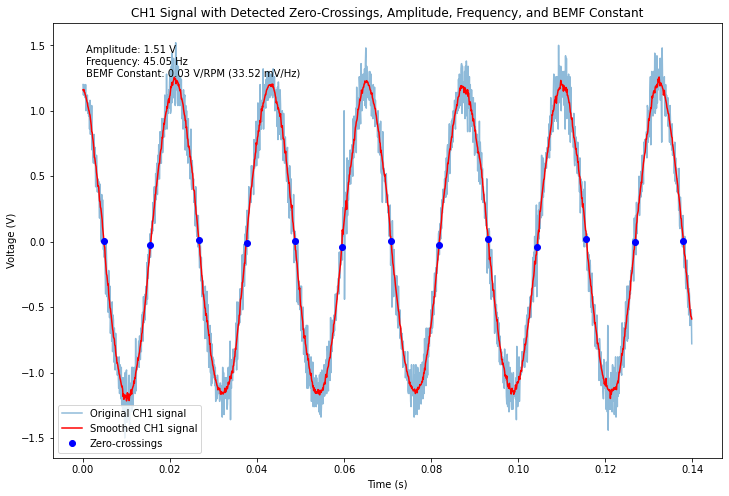

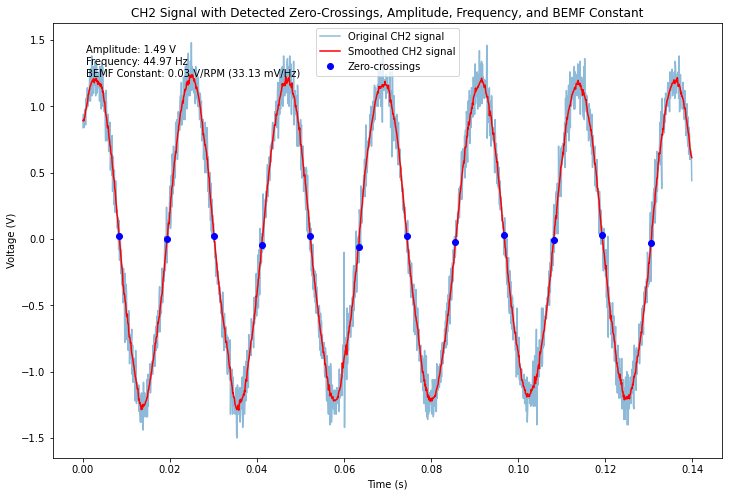

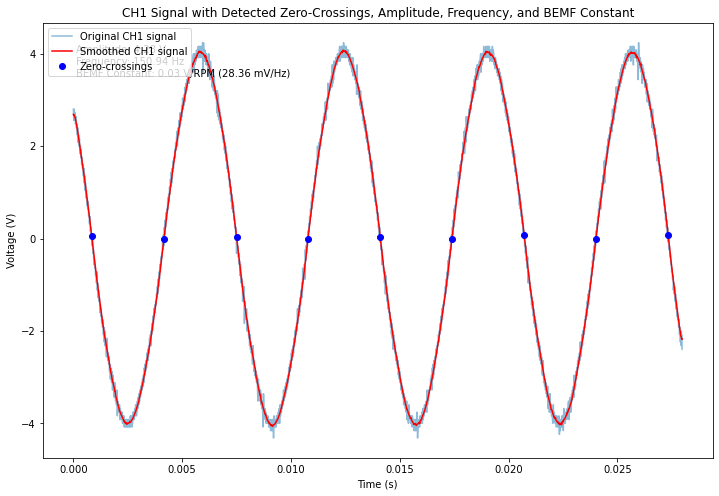

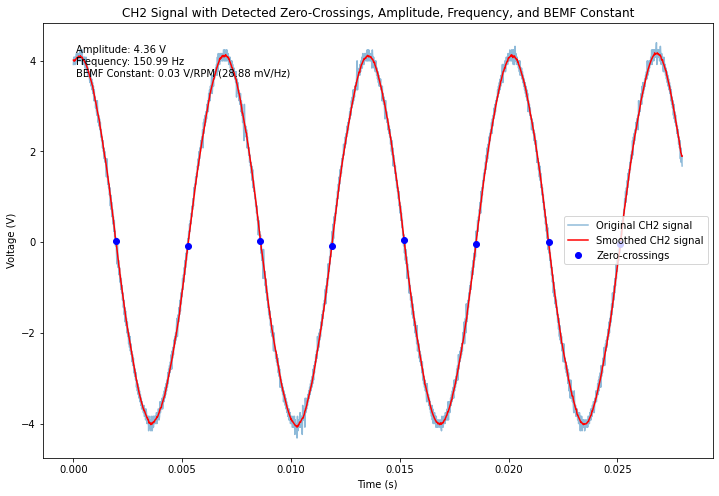

Average amplitude CH1: 2.895
Average amplitude CH2: 2.9250000000000003
Average frequency CH1: 97.99422063573006
Average frequency CH2: 97.98180826649414
Average kt CH1: 0.0309385
Average kt CH2: 0.03100391948051948
Average kt (mV/Hz) CH1: 30.9385
Average kt (mV/Hz) CH2: 31.00391948051948


In [2]:

# List of files to process
files = ['measurements/df45m024053-a2_slow.csv', 'measurements/df45m024053-a2_fast.csv']


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.ndimage.filters import uniform_filter1d

def process_file(filepath):
    # Load the data
    data = pd.read_csv(filepath)

    # Get the time increment from the original data
    time_increment = float(data['Increment'].iloc[0])

    # Remove the first row (unit labels)
    data = data.iloc[1:]

    # Convert the data to the correct types
    data['X'] = pd.to_numeric(data['X'])
    data['CH1'] = pd.to_numeric(data['CH1'])
    data['CH2'] = pd.to_numeric(data['CH2'])

    # Set the window size for uniform mean
    window_size = 10

    # Calculate the uniform mean of the signals
    CH1_smooth = uniform_filter1d(data['CH1'], window_size)
    CH2_smooth = uniform_filter1d(data['CH2'], window_size)

    # Create a time array based on the number of samples and the time increment
    time_array = np.arange(0, len(data['X']) * time_increment, time_increment)

    # Find the zero-crossings
    zero_crossings_CH1 = np.where(np.diff(np.sign(CH1_smooth)))[0]
    zero_crossings_CH2 = np.where(np.diff(np.sign(CH2_smooth)))[0]

    # Use these zero-crossings to calculate the period and frequency
    period_CH1 = np.mean(np.diff(time_array[zero_crossings_CH1]))
    period_CH2 = np.mean(np.diff(time_array[zero_crossings_CH2]))

    # Correct the frequency calculation by dividing the frequency by 2
    frequency_CH1 = 1 / period_CH1 / 2
    frequency_CH2 = 1 / period_CH2 / 2

    # Calculate amplitude in the original signal using maxima and minima
    amplitude_CH1 = (np.max(data['CH1']) - np.min(data['CH1'])) / 2
    amplitude_CH2 = (np.max(data['CH2']) - np.min(data['CH2'])) / 2

    # Calculate the BEMF constant
    kt_CH1 = amplitude_CH1 / (frequency_CH1)  # Convert frequency from Hz to RPM
    kt_CH2 = amplitude_CH2 / (frequency_CH2)

    # Convert the BEMF constant to mV/Hz
    kt_mV_Hz_CH1 = kt_CH1 * 1000  # Convert V/Hz to mV/Hz
    kt_mV_Hz_CH2 = kt_CH2 * 1000  # Convert V/Hz to mV/Hz

    # Plot the original and smoothed signals for CH1
    plt.figure(figsize=(12, 8))
    plt.plot(time_array, data['CH1'].values, label='Original CH1 signal', alpha=0.5)
    plt.plot(time_array, CH1_smooth, 'r', label='Smoothed CH1 signal')

    # Plot the zero-crossings
    plt.plot(time_array[zero_crossings_CH1], CH1_smooth[zero_crossings_CH1], 'bo', label='Zero-crossings')

    # Add the amplitude, frequency, and BEMF constant to the plot
    plt.text(0.05, 0.95, f'Amplitude: {amplitude_CH1:.2f} V\nFrequency: {frequency_CH1:.2f} Hz\nBEMF Constant: {kt_CH1:.2f} V/RPM ({kt_mV_Hz_CH1:.2f} mV/Hz)',
             transform=plt.gca().transAxes, va='top')

    plt.xlabel('Time (s)')
    plt.ylabel('Voltage (V)')
    plt.title('CH1 Signal with Detected Zero-Crossings, Amplitude, Frequency, and BEMF Constant')
    plt.legend()

    # Repeat the process for CH2
    plt.figure(figsize=(12, 8))
    plt.plot(time_array, data['CH2'].values, label='Original CH2 signal', alpha=0.5)
    plt.plot(time_array, CH2_smooth, 'r', label='Smoothed CH2 signal')

    plt.plot(time_array[zero_crossings_CH2], CH2_smooth[zero_crossings_CH2], 'bo', label='Zero-crossings')

    plt.text(0.05, 0.95, f'Amplitude: {amplitude_CH2:.2f} V\nFrequency: {frequency_CH2:.2f} Hz\nBEMF Constant: {kt_CH2:.2f} V/RPM ({kt_mV_Hz_CH2:.2f} mV/Hz)',
             transform=plt.gca().transAxes, va='top')

    plt.xlabel('Time (s)')
    plt.ylabel('Voltage (V)')
    plt.title('CH2 Signal with Detected Zero-Crossings, Amplitude, Frequency, and BEMF Constant')
    plt.legend()

    plt.show()


    # Return the calculated parameters
    return {
        'amplitude_CH1': amplitude_CH1,
        'amplitude_CH2': amplitude_CH2,
        'frequency_CH1': frequency_CH1,
        'frequency_CH2': frequency_CH2,
        'kt_CH1': kt_CH1,
        'kt_CH2': kt_CH2,
        'kt_mV_Hz_CH1': kt_mV_Hz_CH1,
        'kt_mV_Hz_CH2': kt_mV_Hz_CH2
    }

# Process each file and store the results
results = []
for file in files:
    result = process_file(file)
    results.append(result)

# Calculate the averages
average_amplitude_CH1 = np.mean([result['amplitude_CH1'] for result in results])
average_amplitude_CH2 = np.mean([result['amplitude_CH2'] for result in results])
average_frequency_CH1 = np.mean([result['frequency_CH1'] for result in results])
average_frequency_CH2 = np.mean([result['frequency_CH2'] for result in results])
average_kt_CH1 = np.mean([result['kt_CH1'] for result in results])
average_kt_CH2 = np.mean([result['kt_CH2'] for result in results])
average_kt_mV_Hz_CH1 = np.mean([result['kt_mV_Hz_CH1'] for result in results])
average_kt_mV_Hz_CH2 = np.mean([result['kt_mV_Hz_CH2'] for result in results])

print(f'Average amplitude CH1: {average_amplitude_CH1}')
print(f'Average amplitude CH2: {average_amplitude_CH2}')
print(f'Average frequency CH1: {average_frequency_CH1}')
print(f'Average frequency CH2: {average_frequency_CH2}')
print(f'Average kt CH1: {average_kt_CH1}')
print(f'Average kt CH2: {average_kt_CH2}')
print(f'Average kt (mV/Hz) CH1: {average_kt_mV_Hz_CH1}')
print(f'Average kt (mV/Hz) CH2: {average_kt_mV_Hz_CH2}')
